In [1]:
import pandas as pd
import numpy as np

In [2]:
movies = pd.read_csv('./movielens/ml-20m/movies.csv', sep=',') #read the main data files being used
print(type(movies))
movies.head(15)

<class 'pandas.core.frame.DataFrame'>


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [3]:
ratings = pd.read_csv('./movielens/ml-20m/ratings.csv', sep=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
tags = pd.read_csv('./movielens/ml-20m/tags.csv', sep=',')
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


Data cleaning

1 - Find highly-rated movies

From intro: find mean rating for each movie, dropping NaN (Nov 4)

In [5]:
#avg_ratings = ratings.groupby('movieId').mean() #asindex = False: new indices from 0 as row indicies, not movieId
#del mean_ratings['timestamp']
#del mean_ratings['userId']
mean_ratings = ratings.rating.groupby(ratings.movieId).mean()
mean_ratings.isnull().any()

False

In [6]:
movies_with_mean_ratings = movies.assign(rating = mean_ratings)
movies_with_mean_ratings.isnull().any()
movies_with_mean_ratings.describe()

,movieId,rating
count,27278.000000,9259.000000
mean,59855.480570,3.182240
std,44429.314697,0.542564
min,1.000000,0.500000
25%,6931.250000,2.838200
50%,68068.000000,3.250000
75%,100293.250000,3.587575
max,131262.000000,5.000000


In [7]:
movies_with_mean_ratings = movies_with_mean_ratings.dropna()

In [8]:
movies_with_mean_ratings.head()
movies_with_mean_ratings.describe()

,movieId,rating
count,9259.000000,9259.000000
mean,17670.244411,3.182240
std,36685.299899,0.542564
min,2.000000,0.500000
25%,2484.500000,2.838200
50%,4820.000000,3.250000
75%,7167.500000,3.587575
max,131262.000000,5.000000


In [9]:
is_highly_rated = movies_with_mean_ratings.rating >= 4.0 #apply filter
highly_rated_movies = movies_with_mean_ratings[is_highly_rated]

In [10]:
highly_rated_movies.describe()

,movieId,rating
count,313.000000,313.000000
mean,13840.827476,4.101465
std,35084.335429,0.101945
min,29.000000,4.000000
25%,1223.000000,4.033347
50%,2415.000000,4.080879
75%,5717.000000,4.143087
max,131120.000000,5.000000


In [11]:
all_highly_rated_movies = movies_with_mean_ratings.reindex(highly_rated_movies['movieId'])
#need last []! want movieId column as new index, otherwise good_movies len=0, all NaN after reindex

In [12]:
all_highly_rated_movies.describe() 
#len(all_highly_rated_movies)

,movieId,rating
count,286.000000,286.000000
mean,4898.412587,3.384396
std,13297.679555,0.607425
min,30.000000,1.000000
25%,1194.500000,3.076533
50%,2110.000000,3.509397
75%,4004.000000,3.829729
max,125926.000000,4.256935


Check for empty rows

In [13]:
#is any row NULL ?

all_highly_rated_movies.isnull().any()

movieId    True
title      True
genres     True
rating     True
dtype: bool

In [14]:
#how many rows are null (not highly rated?*)?
all_highly_rated_movies.isnull().sum()

movieId    27
title      27
genres     27
rating     27
dtype: int64

In [15]:
good_movies = all_highly_rated_movies.dropna()

In [16]:
#Check again, is any row NULL ?

good_movies.isnull().any()

movieId    False
title      False
genres     False
rating     False
dtype: bool

In [17]:
all_highly_rated_movies.describe() #Why is this same as before dropna?
good_movies.dropna().describe()

,movieId,rating
count,286.000000,286.000000
mean,4898.412587,3.384396
std,13297.679555,0.607425
min,30.000000,1.000000
25%,1194.500000,3.076533
50%,2110.000000,3.509397
75%,4004.000000,3.829729
max,125926.000000,4.256935


In [18]:
len(good_movies)
#len(all_highly_rated_movies)

286

2 - Among movies with good ratings, find movies that have a low number of ratings (unpopular)

In [19]:
num_ratings = ratings.movieId.value_counts()
num_ratings.mean()

747.8411232425965

In [20]:
num_ratings.median()

18.0

In [21]:
num_ratings_unpopular = num_ratings[num_ratings <= num_ratings.mean()] #apply filter, less than mean number of ratings; can't do both >1 and <748?
#num_ratings.mean()
num_ratings_unpopular.head()

73268    747
1626     747
45442    745
209      745
3857     745
Name: movieId, dtype: int64

In [22]:
num_ratings_unpopular.describe()

count    23048.000000
mean        76.776987
std        143.124263
min          1.000000
25%          2.000000
50%         10.000000
75%         72.000000
max        747.000000
Name: movieId, dtype: float64

In [23]:
num_ratings_unpopular_select = num_ratings_unpopular[num_ratings_unpopular > num_ratings.median()]
##* to prevent movies with only 1 or 2 reviews skewing result, only consider movies with the number of ratings larger than median, smaller than mean
num_ratings_unpopular_select.median()
num_ratings_unpopular_select.tail()

52845    19
34488    19
5405     19
32902    19
25800    19
Name: movieId, dtype: int64

In [51]:
num_ratings_unpopular_select.describe()

count    9579.000000
mean      178.003863
std       178.120197
min        19.000000
25%        44.000000
50%       102.000000
75%       256.000000
max       747.000000
Name: movieId, dtype: float64

In [158]:
##Need to reindex again before merging? or merge before reindexing? 

#all_highly_rated_movies = movies_with_mean_ratings.reindex(highly_rated_movies['movieId'])
#num_ratings_ranked = num_ratings_unpopular_select.reindex(num_ratings_unpopular_select)
#good_movies.assign(rating = ) ##how to match numratings (working in movieId column) back to good_movies with title and mean?

In [37]:
testjoin = pd.concat([num_ratings_unpopular_select, good_movies],axis = 1, join_axes = [num_ratings_unpopular_select.index])
#testjoin = pd.concat([num_ratings_unpopular_select, good_movies],axis = 1, join='inner')

In [38]:
testjoin.describe()

,movieId,movieId,rating
count,9579.000000,120.000000,120.000000
mean,178.003863,7430.758333,3.079038
std,178.120197,19377.118506,0.542642
min,19.000000,52.000000,1.625000
25%,44.000000,1346.000000,2.753642
50%,102.000000,3499.000000,3.187888
75%,256.000000,6175.000000,3.512197
max,747.000000,125926.000000,3.877615


In [40]:
testjoin.head()

,movieId,movieId,title,genres,rating
73268,747,NaN,NaN,NaN,NaN
1626,747,NaN,NaN,NaN,NaN
45442,745,NaN,NaN,NaN,NaN
209,745,NaN,NaN,NaN,NaN
3857,745,NaN,NaN,NaN,NaN


In [42]:
testjoin.dropna().describe()

,movieId,movieId,rating
count,120.000000,120.000000,120.000000
mean,224.350000,7430.758333,3.079038
std,188.336756,19377.118506,0.542642
min,19.000000,52.000000,1.625000
25%,68.750000,1346.000000,2.753642
50%,159.500000,3499.000000,3.187888
75%,341.000000,6175.000000,3.512197
max,733.000000,125926.000000,3.877615


In [43]:
testjoin.dropna().head() #**Nov25 merging still not right, choose index of which df as axis for merging??

,movieId,movieId,title,genres,rating
1332,733,1363.0,"Preacher's Wife, The (1996)",Drama,3.015689
2817,726,2903.0,Psycho III (1986),Horror|Thriller,1.677686
4077,712,4171.0,Long Night's Journey Into Day (2000),Documentary,3.607444
7228,701,7340.0,Just One of the Guys (1985),Comedy,2.397290
3017,685,3104.0,Midnight Run (1988),Action|Comedy|Crime|Thriller,2.677372


**Dec 4 -- from wk 5 notebook, create masks for plotting instead of merging?**

* more findings needed?? Explore data further: filter by genre:

In [75]:
#good_indie_movies = good_movies.merge(ratings.num_ratings_unpopular_select,on='movieId', how='inner')

AttributeError: 'DataFrame' object has no attribute 'num_ratings_unpopular_select'

In [116]:
def filter_by_genre(input_movies, genre):
    """Return only movies of a specific genre"""
    return input_movies[input_movies['genres'].str.contains(genre)]

In [117]:
drama_movies = filter_by_genre(unpopular_movies, "Romance")

NameError: name 'unpopular_movies' is not defined

In [ ]:
#is_drama_or_romance = movies['genres'].str.contains('Drama','Romance')
#'genres' column in the movie table, value will be a string value, check and see if the str contains 'drama' or 'romance'
#contains is a str ftn (later), gives T or F values
#movies[is_drama_or_romance][:15]

In [ ]:
unpopular[is_drama_or_romance][:15]

Merging movies and ratings

In [ ]:
#movie_rating = movies.merge(ratings, on='movieId', how='inner')
#movie_rating.head()
movie_count_rating = movies.merge(ratings, on='movieId', how='inner')
movie_count_rating.head()

In [ ]:
unpopular = movie_rating['rating'] <= 748 #apply filter, less than mean number of ratings; can't do both >1 and <748?
movie_rating[unpopular].head(10) #check filter again? want to filter count of ratings for each movie, not indvl ratings

In [ ]:
#Find the maximum rating
max_rating = ratings['rating'].max()
max_rating

In [ ]:
#Count how many ratings are there in our database for each movieID.
num_ratings = ratings.movieId.value_counts()
num_ratings.head()

In [ ]:
unpopular = movie_rating['rating'] <= 748 #apply filter, less than mean number of ratings; can't do both >1 and <748?
movie_rating[unpopular].head(10) #check filter again? want to filter count of ratings for each movie, not indvl ratings

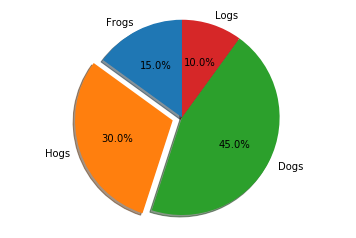

In [57]:
#pie chart example 
"""
===============
Basic pie chart
===============

Demo of a basic pie chart plus a few additional features.

In addition to the basic pie chart, this demo shows a few optional features:

    * slice labels
    * auto-labeling the percentage
    * offsetting a slice with "explode"
    * drop-shadow
    * custom start angle

Note about the custom start angle:

The default ``startangle`` is 0, which would start the "Frogs" slice on the
positive x-axis. This example sets ``startangle = 90`` such that everything is
rotated counter-clockwise by 90 degrees, and the frog slice starts on the
positive y-axis.
"""
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()